In [27]:
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
from scipy.optimize import curve_fit

plt.style.use('~/light_mode.mplstyle')
%matplotlib inline

## Read in the data

In [2]:
POWER_UNIT = r'$\mathrm{mV^2}$'

In [3]:
DATA_DIR = '/Users/darbymccauley/taurus/cryo_fts/scan_data/'
DATA_FILE = '20251210_185512.npz'
data = np.load(os.path.join(DATA_DIR, DATA_FILE))

for key in data.keys():
    print(key)

Date
RES_mm
NINT
NSTEPS
X_V
Y_V
R_V
THETA_deg
ENCODER_POS_mm


In [4]:
RES = data['RES_mm'] * u.mm
print(f'RESOLUTION: {RES}')
NSTEPS = data['NSTEPS']
R = data['R_V'] * u.V
R_rebinned = R.reshape(NSTEPS, 50).mean(axis=1).to(u.mV) # for an older data collection script
I = (R_rebinned - np.mean(R_rebinned))

# the 'ENCODER_POS_mm' key is reading counts for this data file rather than physical position so need to do this work around to get the actual position and OPD:
ENC_RES = 0.244140625 * u.um
OFFSET = data['ENCODER_POS_mm'][0]
POS = ((data['ENCODER_POS_mm'] - OFFSET) * ENC_RES).to(u.mm)
OPD = POS * 2

#dOPD is not constant, so interpolate the interferrogram
dopd = np.diff(np.sort(OPD))
dopd_min = dopd.min()
OPD_INTERP = np.linspace(OPD.min(), OPD.max(), OPD.size)
I_INTERP = np.interp(OPD_INTERP, OPD, I)
# window = np.hanning(OPD.size)
# I_INTERP *= window

SPECTRUM = np.fft.rfft(I_INTERP)
POWER = np.abs(SPECTRUM)**2
WAVENUMBERS = np.fft.rfftfreq(OPD_INTERP.size, np.diff(OPD_INTERP).mean()).to(1/u.cm)
FREQS = WAVENUMBERS.to(u.GHz, equivalencies=u.spectral())

RESOLUTION: 0.15 mm


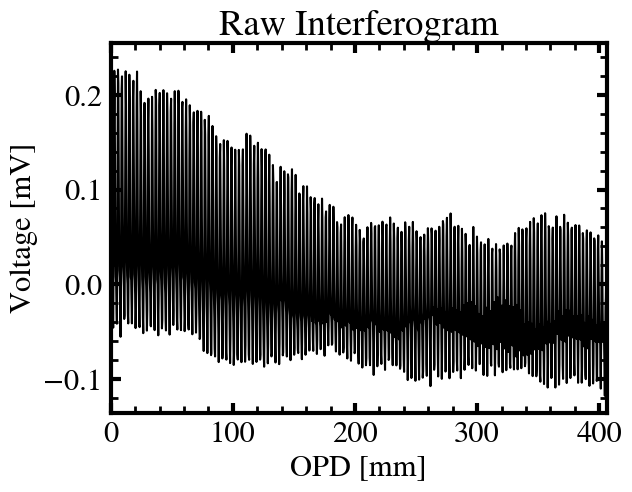

In [5]:
fig, axes = plt.subplots(1,1)
axes.set_title('Raw Interferogram')
axes.plot(OPD_INTERP, I_INTERP, 'k', lw=1.5)
axes.set_ylabel(rf'Voltage [mV]')
axes.set_xlabel(rf'OPD [{OPD.unit}]')
axes.set_xlim(0, OPD_INTERP.value.max())
plt.show()

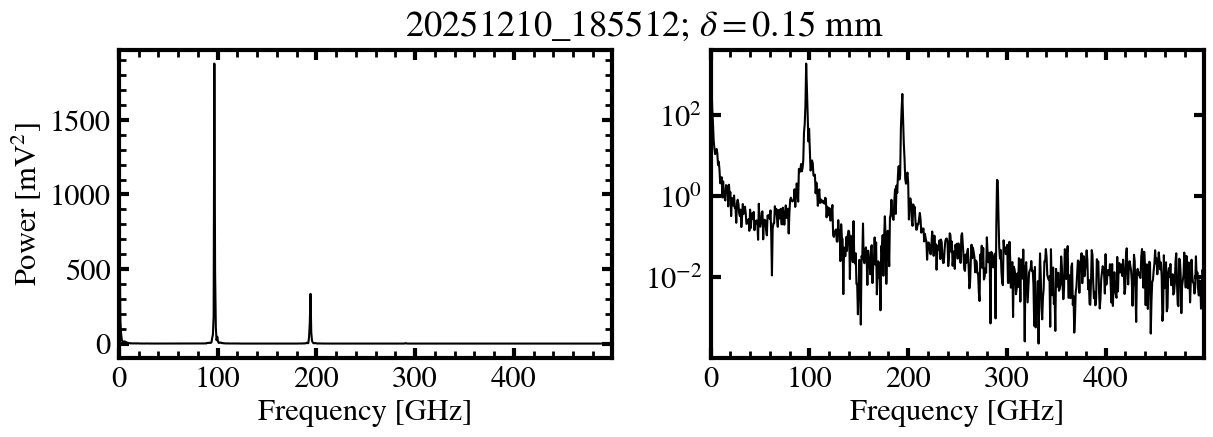

In [24]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle(rf'{DATA_FILE.split('.')[0]}; $\delta=${RES}')

axes[0].plot(FREQS, POWER, color='k', lw=1.5)
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
axes[0].set_xlim(0, FREQS.value.max())

axes[1].semilogy(FREQS, POWER, color='k', lw=1.5)
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
plt.show()

## Noise and bandpass modeling

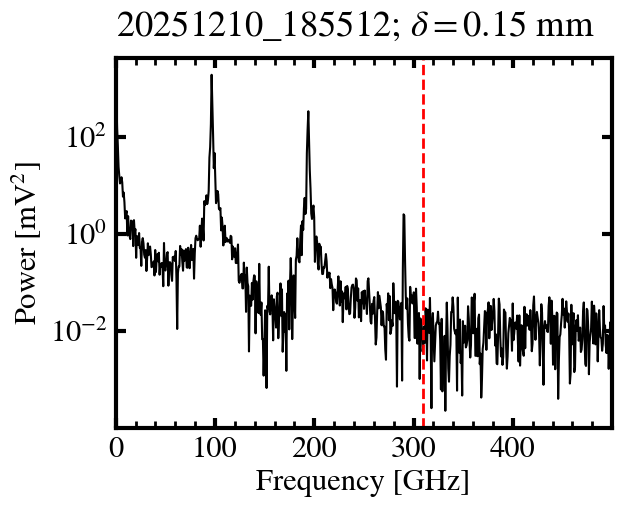

In [7]:
fig, axes = plt.subplots(1, 1)
fig.suptitle(rf'{DATA_FILE.split('.')[0]}; $\delta=${RES}')
axes.semilogy(FREQS, POWER, color='k', lw=1.5)
axes.set_xlabel(rf'Frequency [{FREQS.unit}]')
axes.set_ylabel(rf'Power [{POWER_UNIT}]')
axes.set_xlim(0, FREQS.value.max())
# axes.set_ylim(1e-3, 1e3)
axes.vlines(310, 1e-4, 1e4, color='r', linestyle='--', lw=2)
plt.show()

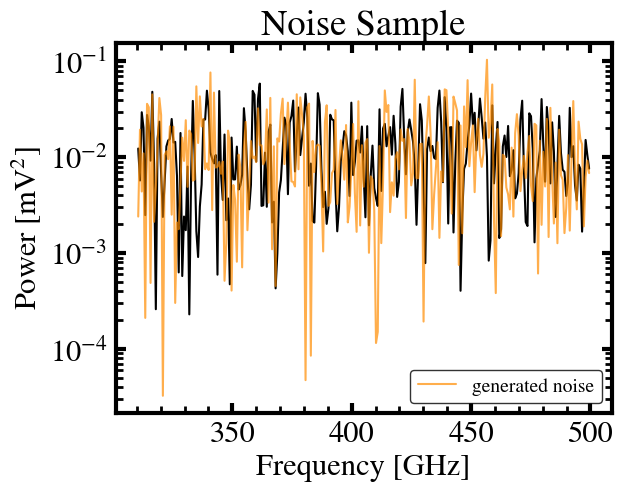

In [8]:
noise_thresh = 310 * u.GHz
idx = np.where(FREQS > noise_thresh)[0]
noise_mean = np.mean(POWER[idx])
noise_std = np.std(POWER[idx])
# noise_sample = np.random.normal(loc=noise_mean.value, scale=noise_std.value, size=idx.size)
noise_sample = np.random.exponential(scale=noise_mean.value, size=idx.size)

plt.figure()
plt.title('Noise Sample')
plt.semilogy(FREQS[idx], POWER[idx], color='k', lw=1.5)
plt.semilogy(FREQS[idx], noise_sample, lw=1.5, color='darkorange', alpha=0.7, label='generated noise')
plt.xlabel(rf'Frequency [{FREQS.unit}]')
plt.ylabel(rf'Power [{POWER_UNIT}]')
plt.legend(fontsize=14)
plt.show()

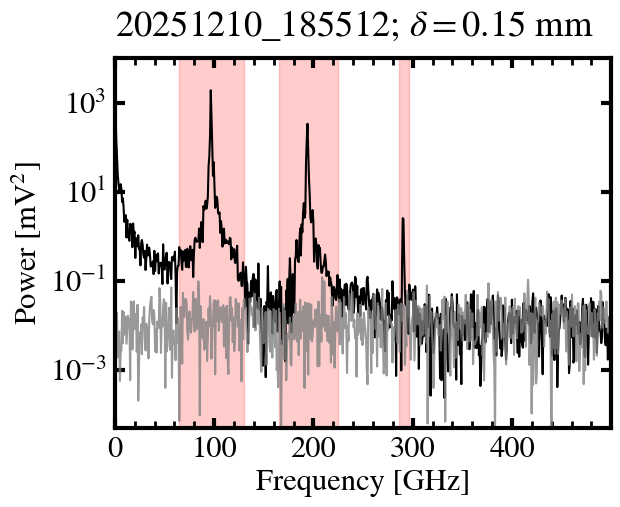

In [9]:
# noise = np.abs(np.random.normal(loc=noise_mean.value, scale=noise_std.value, size=POWER.size)) * POWER.unit
noise = np.random.exponential(scale=noise_mean.value, size=POWER.size) * POWER.unit

# %matplotlib widget
fig, axes = plt.subplots(1, 1)
ymin, ymax = 5e-5, 1e4
fig.suptitle(rf'{DATA_FILE.split('.')[0]}; $\delta=${RES}')
axes.plot(FREQS, POWER, color='k', lw=1.5)
axes.plot(FREQS, noise, color='grey', lw=1.5, alpha=0.8)
axes.set_xlabel(rf'Frequency [{FREQS.unit}]')
axes.set_ylabel(rf'Power [{POWER_UNIT}]')
axes.set_xlim(0, FREQS.value.max())
axes.set_ylim(ymin, ymax)
axes.set_yscale('log')

peak_regions = [(65, 130), (165, 225), (286, 296)]  # GHz
mask = np.ones(FREQS.size, dtype=bool)
for x1, x2 in peak_regions:
    mask &= ~((FREQS.value >= x1) & (FREQS.value <= x2))
    axes.fill_betweenx(y=np.linspace(ymin, ymax), x1=x1, x2=x2, color='red', alpha=0.2)
passband = POWER.copy()
passband[~mask] = np.nan

plt.show()

In [10]:
def powerlaw_model(f, m, b):
    return 10**b * f**m

def pink_noise_model(f, alpha, b):
    return 1.0 / (f**alpha) * 10.0**b

thresh = 10 * u.GHz

f_vals = FREQS.to(u.GHz).value
pb_vals = passband.value
valid_mask = ~np.isnan(pb_vals)

high_freqs_mask = valid_mask & (f_vals > thresh.to(u.GHz).value)
low_freqs_mask = valid_mask & (f_vals > 0) & (f_vals <= thresh.to(u.GHz).value)

pl_slope, pl_intercept = np.polyfit(np.log10(f_vals[high_freqs_mask]), np.log10(pb_vals[high_freqs_mask]), 1)
powerlaw = powerlaw_model(f_vals, pl_slope, pl_intercept)

guesses = np.array([1.0, np.log10(np.nanmedian(pb_vals[low_freqs_mask]))])
pink_pars, _ = curve_fit(pink_noise_model, f_vals[low_freqs_mask], pb_vals[low_freqs_mask], p0=guesses)
pink_slope, pink_intercept = pink_pars
pink = pink_noise_model(f_vals, pink_slope, pink_intercept)

tot_mod = np.where(f_vals < thresh.to(u.GHz).value, pink, powerlaw)
passband_model = tot_mod * passband.unit

/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_83082/4035870966.py:2: RuntimeWarning: divide by zero encountered in power
  return 10**b * f**m
/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_83082/4035870966.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / (f**alpha) * 10.0**b


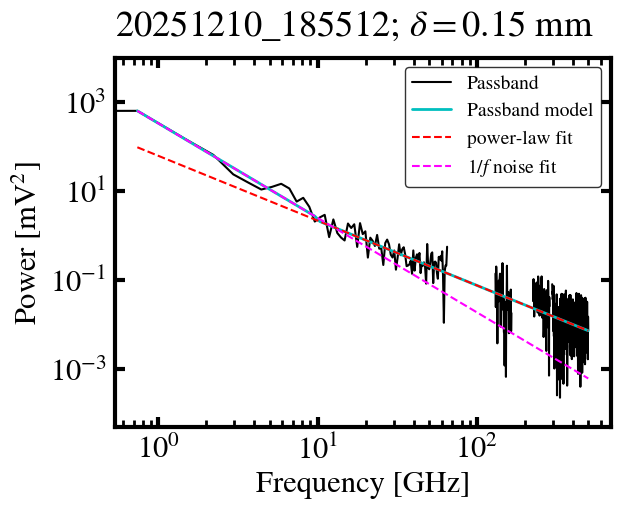

In [11]:
fig, axes = plt.subplots()
fig.suptitle(rf'{DATA_FILE.split('.')[0]}; $\delta=${RES}')
axes.loglog(FREQS, passband, 'k', lw=1.5, label='Passband')
axes.loglog(FREQS, passband_model, color='c', lw=2, label='Passband model')
axes.loglog(FREQS, powerlaw, 'r--', lw=1.5, label='power-law fit')
axes.loglog(FREQS, pink, color='magenta', ls='--', lw=1.5 , label=r'$1/f$ noise fit')
axes.legend(fontsize=14)
axes.set_xlabel(rf'Frequency [{FREQS.unit}]')
axes.set_ylabel(rf'Power [{POWER_UNIT}]')
axes.set_ylim(ymin, ymax)
plt.show()

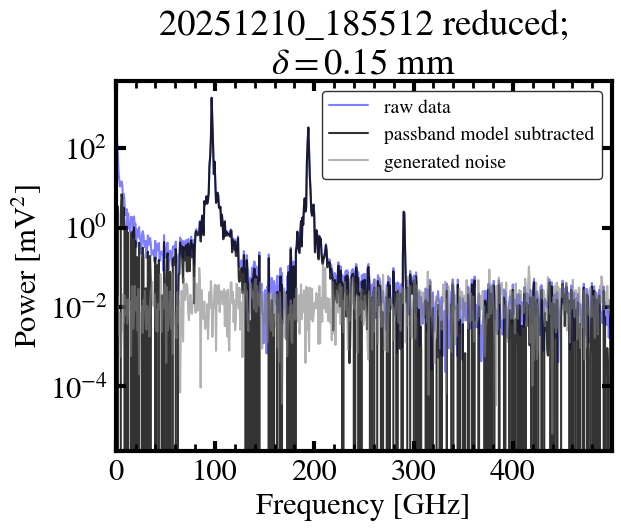

In [12]:
fig, axes = plt.subplots()
axes.set_title(f'{DATA_FILE.split('.')[0]} reduced;\n' + rf'$\delta=${RES}')
axes.plot(FREQS, POWER, 'b', lw=1.5, label='raw data', alpha=0.5)
axes.plot(FREQS, POWER - passband_model, 'k', lw=1.5, label='passband model subtracted', alpha=0.8)
axes.plot(FREQS, noise, 'grey', lw=1.5, label='generated noise', alpha=0.6)
axes.legend(fontsize=14)
axes.set_xlabel(rf'Frequency [{FREQS.unit}]')
axes.set_ylabel(rf'Power [{POWER_UNIT}]')
axes.set_xlim(0, FREQS.value.max())
axes.set_yscale('log')
axes.set_xscale('linear')
# axes.set_ylim(1e-11, 3e-2)
plt.show()

## Guassian peak fitting of harmonics

In [13]:
def gauss(x, amp, avg, sig):
    ans = amp * np.exp(-(x-avg)**2/(2.*sig**2))
    return ans

def gaussfit(x, y, amp=1., avg=0., sig=1., return_cov=False):
    prms0 = np.array([amp, avg, sig])
    prms, prm_covariance = curve_fit(gauss, x, y, p0=prms0)
    amp, avg, sig = prms
    ans = {'amp':amp, 'avg':avg, 'sig':sig}
    if return_cov:
        return ans, prm_covariance
    else:
        return ans

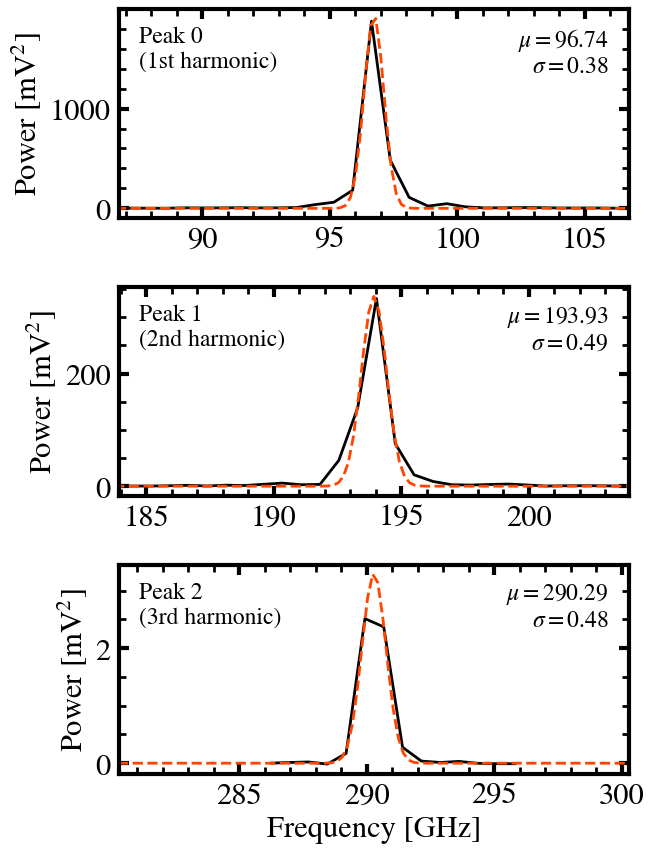

In [14]:
fits = {}
fig, axes = plt.subplots(len(peak_regions), 1, 
                         figsize=(7, 3 * len(peak_regions)),
                         sharex=False, sharey=False, squeeze=True)

for i, (x1, x2) in enumerate(peak_regions):
    mask = (FREQS.value >= x1) & (FREQS.value <= x2)
    x_peak = FREQS.to(u.GHz).value[mask]
    y_peak = (POWER - passband_model).value[mask]

    axes[i].plot(x_peak, y_peak, color='k', lw=2)
    fit_pars = gaussfit(x_peak, y_peak, amp=np.max(y_peak), avg=np.median(x_peak), sig=1, return_cov=False)
    key = f'peak{i+1}'
    fits[key] = fit_pars
    # print(f'PEAK {i+1}: {fit_pars}')
    xrange = np.linspace(-np.max(FREQS.value), np.max(FREQS.value), 5000)
    axes[i].plot(xrange, gauss(xrange, amp=fit_pars['amp'], avg=fit_pars['avg'], sig=fit_pars['sig']), 
                 color='orangered', lw=2, ls='dashed')

    axes[i].set_xlim(fit_pars['avg']-10, fit_pars['avg']+10)
    axes[i].set_ylabel(rf'Power [{POWER_UNIT}]')

    txt1 = f'Peak {i}'
    if i == 0: txt1 = txt1 + '\n' + '(1st harmonic)'
    if i == 1: txt1 = txt1 + '\n' + '(2nd harmonic)'
    if i == 2: txt1 = txt1 + '\n' + '(3rd harmonic)'
    axes[i].text(0.04, 0.92, txt1, transform=axes[i].transAxes, va='top', fontsize=17,
                 bbox=dict(facecolor='None', alpha=0.7, edgecolor='none'))
    
    txt2 = rf'$\mu={fit_pars['avg']:.2f}$' + '\n' + rf'$\sigma={fit_pars['sig']:.2f}$'
    axes[i].text(0.96, 0.92, txt2, transform=axes[i].transAxes, va='top', ha='right', fontsize=17,
                 bbox=dict(facecolor='None', alpha=0.7, edgecolor='none'))

axes[2].set_xlabel(rf'Frequency [{FREQS.unit}]')
plt.tight_layout()
plt.show()

In [39]:
nyq_freq = (const.c / (2 * RES)).to(u.GHz)
print(nyq_freq)
delta_freq = (const.c / (2 * OPD.max())).to(u.GHz)
print(delta_freq)

def FWHM(sig):
    return 2 * np.sqrt(2 * np.log(2)) * sig

(0.19 * const.c / (OPD.max())).to(u.GHz)

999.3081933333333 GHz
0.3691474834321775 GHz


<Quantity 0.14027604 GHz>

### ???? Want to know if the sigmas measured here are consistent with the resolution limits of our FTS

# Fourier Filtering (low-pass)

In [15]:
clean_power = POWER - passband_model
x1, x2 = peak_regions[0] * u.GHz
mask_peak = (FREQS >= x1) & (FREQS <= x2)
clean_power[~mask_peak] = noise[~mask_peak] 

spec_clean = np.zeros_like(SPECTRUM, dtype=complex)
spec_clean[mask_peak] = SPECTRUM[mask_peak]

## Guassian inpainting
spec_noise_std = np.sqrt(noise / 2)
spec_noise_re = np.random.normal(scale=spec_noise_std) * spec_clean.unit
spec_noise_im = np.random.normal(scale=spec_noise_std) * spec_clean.unit
spec_clean[~mask_peak] = spec_noise_re[~mask_peak] + 1j * spec_noise_im[~mask_peak]

## Inverse FFT to get back cleaned interferogram
I_clean = np.fft.irfft(spec_clean, n=OPD_INTERP.size)

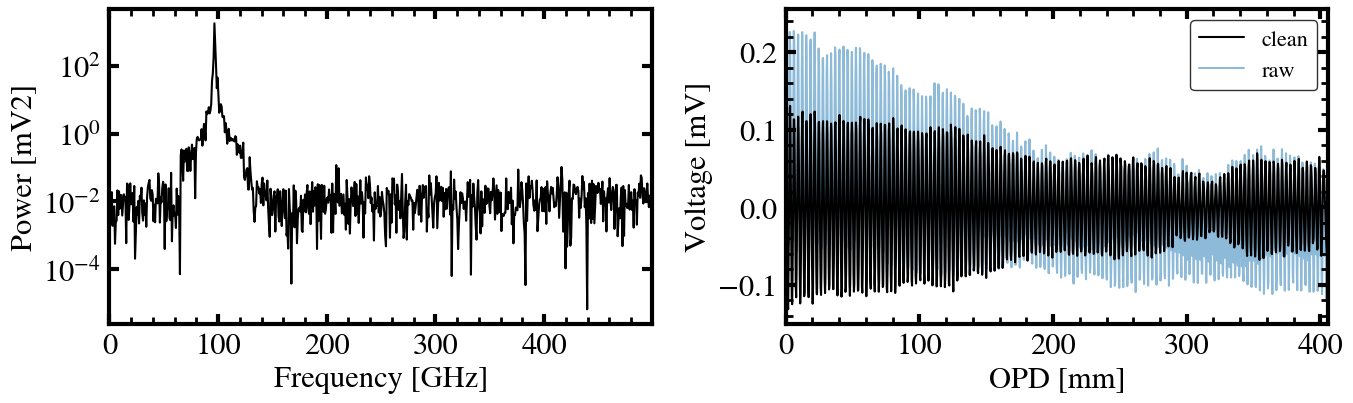

In [ ]:
# %matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

axes[0].semilogy(FREQS, clean_power, color='k', lw=1.5)
axes[0].set_ylabel(f'Power [{clean_power.unit}]')
axes[0].set_xlabel(f'Frequency [{FREQS.unit}]')
axes[0].set_xlim(0, FREQS.value.max())

axes[1].plot(OPD_INTERP, I_clean, lw=1.5, color='k', label='clean')
axes[1].plot(OPD_INTERP, I, lw=1.5, color='C0', alpha=0.5, label='raw', zorder=-1)
axes[1].legend(fontsize=16)
axes[1].set_ylabel(rf'Voltage [{I.unit}]')
axes[1].set_xlabel(rf'OPD [{OPD_INTERP.unit}]')
axes[1].set_xlim(0, OPD_INTERP.value.max())

plt.tight_layout()
plt.show()